In [108]:
from __future__ import print_function
import os
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten,\
                         Dropout,GlobalMaxPooling1D, Lambda, Concatenate, Dense, regularizers
from keras.utils import np_utils
from keras import backend as K
from keras import optimizers, activations

from keras import callbacks
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from matplotlib import pyplot as plt
from IPython.display import clear_output
from scipy.misc import toimage
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="1"


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
print("Using GPU: ", K.tensorflow_backend._get_available_gpus())

K.set_image_dim_ordering('tf')

seed = 10
np.random.seed(seed)

Using GPU:  ['/job:localhost/replica:0/task:0/device:GPU:0']


In [119]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 450
batch_size = 128

In [120]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    
    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    print(labels_.shape)
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [121]:
file_name=('data_batch_1')
image_train, y_train=load_data(file_name)
image_test, y_test=load_data('test_batch')

(10000, 10)
(10000, 10)


The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.
It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.

In [122]:
print(image_train.shape)


# print(test_dic.keys())


X_train = image_train / 255.0
X_test = image_test / 255.0

# Convert class vectors to binary class matrices.

print(y_train.shape)
# y_test = np_utils.to_categorical(y_test, num_classes)

(10000, 3072)
(10000, 10)


In [123]:
print(X_train.shape[0], 'train samples')
#print(X_test.shape[1], 'test samples')
# chans, # images, # rows, # cols)
X_train = X_train.reshape(X_train.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

print(X_train.shape)
print(X_test.shape)

10000 train samples
(10000, 3072)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [124]:
def cross_entropy(y_true, y_pred):
    foo =tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                         logits=y_pred)
    return tf.reduce_mean(foo)

In [125]:
model = Sequential()
### Remember to change to the optimal version
model.add(Conv2D(32, (2, 2),padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), activation='relu',name='con1'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2 ,name='pool1'))
model.add(Conv2D(128,(3,3) ,padding='valid', activation='relu',name='con2'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name='pool2'))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#decay = lrate/epochs
sgd =  optimizers.SGD(lr=learning_rate, momentum=0.1, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())
         


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con1 (Conv2D)                (None, 31, 31, 32)        416       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
con2 (Conv2D)                (None, 13, 13, 128)       36992     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 300)               1382700   
_________________________________________________________________
dense_36 (Dense)             (None, 10)                3010      
Total para

In [43]:
print()

## Plot test accuracy  &&  training loss over   epochs

In [117]:
class PlotLosses(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.legend()
        
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
#        plt.plot(self.x, self.val_losses, label="val_loss")
        
        plt.show();
        
plot_losses = PlotLosses()

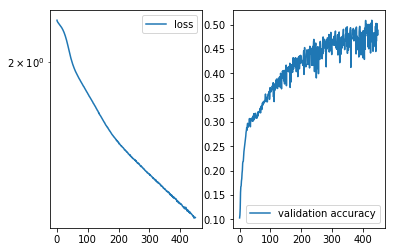

10000/10000 [==============================] - 1s 87us/step - loss: 1.1800 - acc: 0.5929 - val_loss: 1.4289 - val_acc: 0.4884
Test accuracy: 0.4884


In [126]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size,callbacks=[plot_losses])
# Final evaluation of the model

score_test = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_test[1])


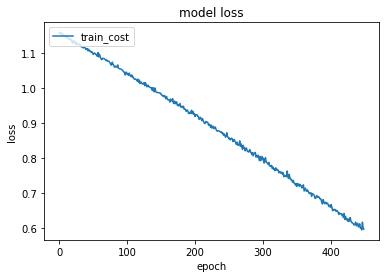

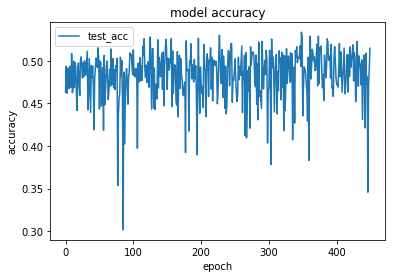

In [88]:
#his1=history
train_loss('a',his1)
test_acc('a',his1)

In [84]:
model = Sequential()
model.add(Conv2D(32, (2, 2),padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), activation='relu',name='con1'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2 ,name='pool1'))
model.add(Conv2D(128,(3,3) ,padding='valid', activation='relu',name='con2'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name='pool2'))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#decay = lrate/epochs
#sgd =  optimizers.SGD(lr=learning_rate, momentum=0.1, decay=0.0, nesterov=False)
#optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
         


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con1 (Conv2D)                (None, 31, 31, 32)        416       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
con2 (Conv2D)                (None, 13, 13, 128)       36992     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               1382700   
_________________________________________________________________
dense_22 (Dense)             (None, 10)                3010      
Total para

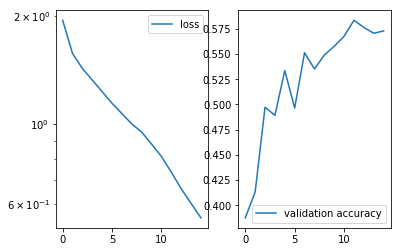

10000/10000 [==============================] - 1s 99us/step - loss: 0.5495 - acc: 0.8193 - val_loss: 1.3778 - val_acc: 0.5728
Test accuracy: 0.5728


In [85]:
epochs = 15

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size,callbacks=[plot_losses])
# Final evaluation of the model

score_test = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_test[1])
his2=history

In [16]:
con_layers = [ layer.name for layer in model.layers]
print(con_layers)

['con1', 'pool1', 'con2', 'batch_normalization_2', 'pool2', 'flatten_2', 'dense_3', 'dense_4']


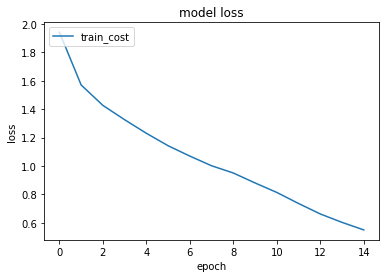

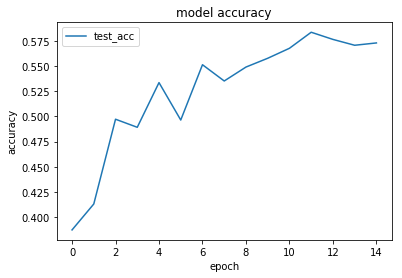

In [94]:
train_loss('b',his2)
test_acc('b',his2)

In [64]:
model = Sequential()
model.add(Conv2D(32, (2, 2),padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), activation='relu',name='con1'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=2 ,name='pool1'))
model.add(Conv2D(128,(3,3) ,padding='valid', activation='relu',name='con2'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name='pool2'))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#decay = lrate/epochs
#sgd =  optimizers.SGD(lr=learning_rate, momentum=0.1, decay=0.0, nesterov=False)
rmsprop=optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
#adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
print(model.summary())
         


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con1 (Conv2D)                (None, 31, 31, 32)        416       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
con2 (Conv2D)                (None, 13, 13, 128)       36992     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 300)               1382700   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                3010      
Total para

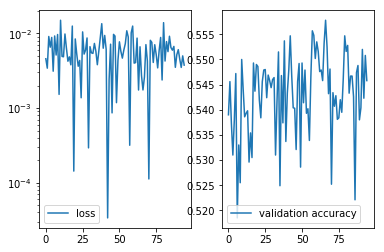

10000/10000 [==============================] - 1s 99us/step - loss: 0.0038 - acc: 0.9986 - val_loss: 5.2281 - val_acc: 0.5458
Test accuracy: 0.5458


In [67]:
epochs = 95

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size,callbacks=[plot_losses])
# Final evaluation of the model

score_test = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_test[1])
his3=history

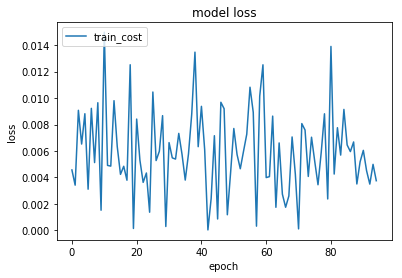

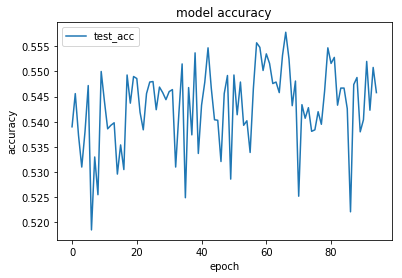

In [95]:
train_loss('c',his3)
test_acc('c',his3)

In [105]:
model = Sequential()
model.add(Conv2D(32, (2, 2),padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), activation='relu',name='con1'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2 ,name='pool1'))
model.add(Conv2D(128,(3,3) ,padding='valid', activation='relu',name='con2'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name='pool2'))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#decay = lrate/epochs
#sgd =  optimizers.SGD(lr=learning_rate, momentum=0.1, decay=0.0, nesterov=False)
#rmsprop=optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
         


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con1 (Conv2D)                (None, 31, 31, 32)        416       
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
con2 (Conv2D)                (None, 13, 13, 128)       36992     
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 128)       0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4608)              0         
__________

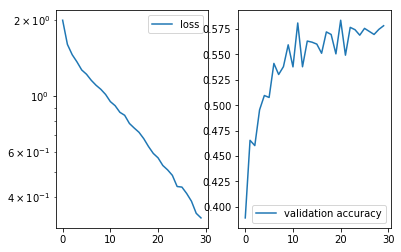

10000/10000 [==============================] - 1s 116us/step - loss: 0.3300 - acc: 0.8848 - val_loss: 1.2991 - val_acc: 0.5782
Test accuracy: 0.5782


In [106]:
epochs = 30

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size,callbacks=[plot_losses])
# Final evaluation of the model

score_test = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_test[1])
his4=history

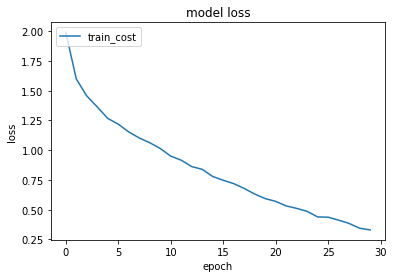

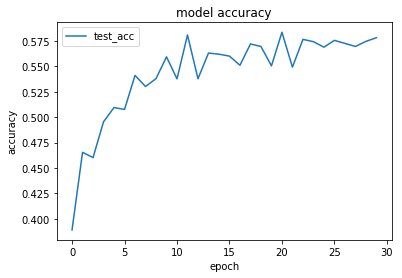

In [107]:
train_loss('d',his4)
test_acc('d',his4)

In [92]:
def train_loss(name,history):
    #training cost 
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_cost'], loc='upper left')
    plt.savefig('./p1_3'+name+'_train_cost_.png')
    plt.show()


In [93]:
def test_acc(name,history):
    # summarize history for accuracy
    # test accuracy 
    #plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['test_acc'], loc='upper left')
    plt.savefig('./p1_3'+name+'_test_acc_.png')
    plt.show()
    # summarize history for loss

In [17]:
pool1_extractor = Model(inputs=model.input, outputs=model.get_layer('con1').output)
X = X_test[1,:]
X=np.asarray(X)

#X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

pool1_featres = pool1_extractor.predict(X)
print(pool1_featres.shape)
# so we gate a numpy array, with 256 features maps, of size 28x28, for 1 element.
#plt.imshow(pool1_featres[0, :, :, 0], cmap='gray')
#plt.show()

(1, 24, 24, 50)


In [65]:
def plot_feature_maps(feature_maps,layer_name):
    height, width, depth = feature_maps.shape
    nb_plot = int(np.rint(np.sqrt(depth)))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(depth):
        plt.axis('off')
        plt.subplot(nb_plot, nb_plot, i+1)
        plt.imshow(feature_maps[:,:,i],cmap='gray')
        #plt.title('feature map {}'.format(i+1))
    plt.savefig('./p1b_2_pool2.png')
#    plt.savefig('./p1b_1_'+layer_name+'.png')
    plt.show()
    
#plot_feature_maps(pool1_featres[0])


At layer "con1" : (24, 24, 50) 


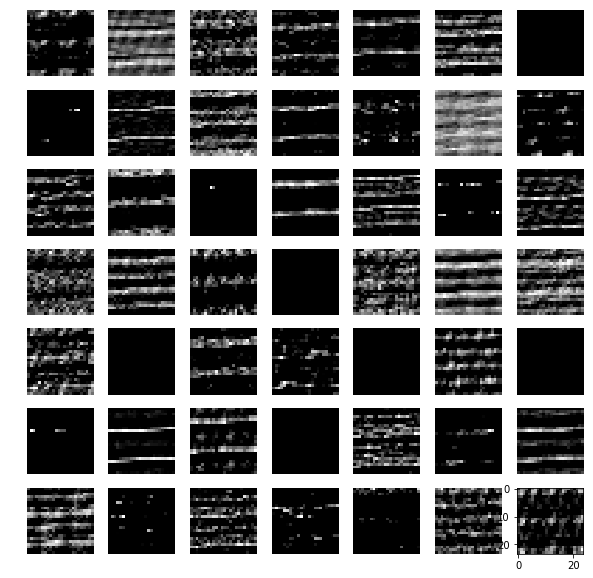

In [63]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
    
plot_layer('con1')

At layer "con2" : (8, 8, 60) 


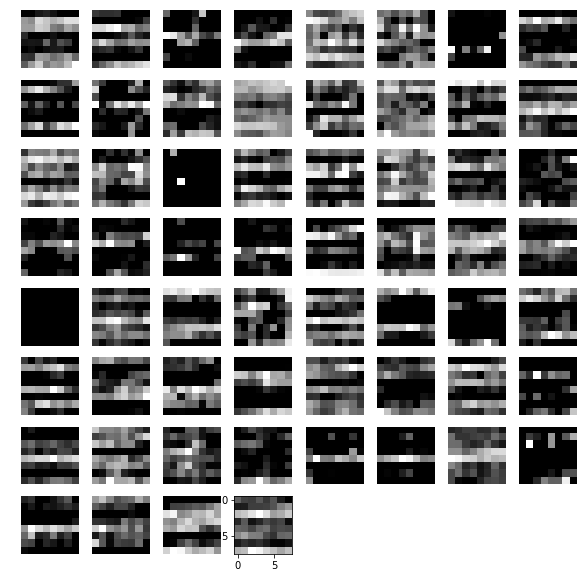

In [66]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('con2')

At layer "pool1" : (12, 12, 50) 


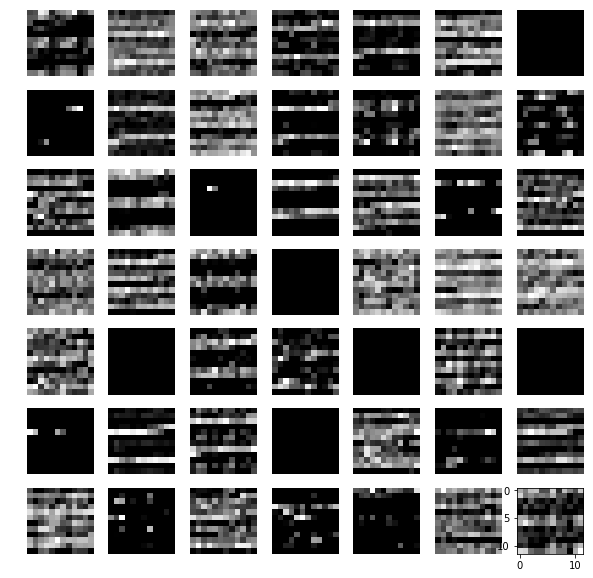

In [64]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('pool1')

At layer "pool2" : (4, 4, 60) 


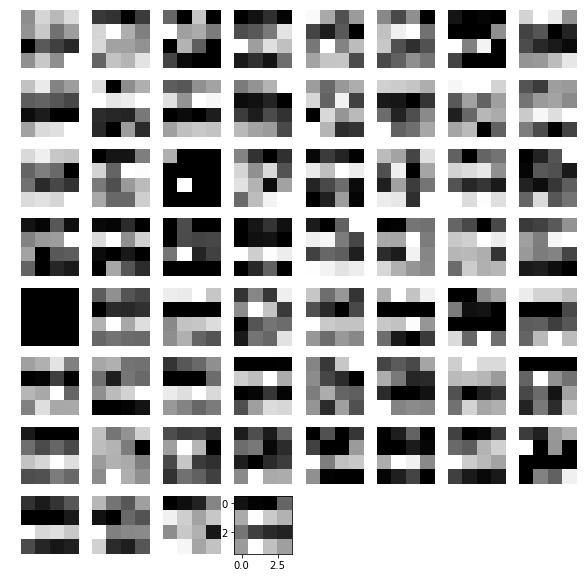

In [67]:
def plot_layer(layer_name):
    # check if the layer_name is correct 
    X = X_test[2,:]
    X=np.asarray(X)

    #X_test = X_test.reshape(X_test.shape[0],IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    X=X.reshape(1,IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
    
    features_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = features_extractor.predict(X)[0]
    print("At layer \"{}\" : {} ".format(layer_name, feature_maps.shape))
    plot_feature_maps(feature_maps,layer_name)
plot_layer('pool2')

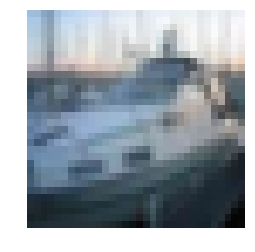

In [70]:
X = X_test[2,:]
X_test_new = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
plt.imshow(X_test_new[:,:])
plt.axis('off')
plt.savefig('./p1b_2_patterns.png')
plt.show()


In [129]:
def feature_map(model):
    ind = np.random.randint(low=0, high=10000)
    X = X_test[ind,:]
#    X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
    X_show=X.reshape(X.shape[0] ,IMG_SIZE, IMG_SIZE,NUM_CHANNELS)

    con_image=model.predict(X_show)
    con_image=np.squeeze(con_image, axis=0)
    plt.axis('off')
    plt.imshow(con_image)    
    plt.figure()
    plt.gray()
    plt.show()

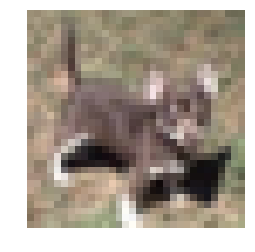

<Figure size 432x288 with 0 Axes>

In [26]:
#ind = np.random.randint(low=0, high=10000)
X = X_test[ind,:]
X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
plt.axis('off')
plt.imshow(X_show)    
plt.figure()
plt.gray()
plt.show()